## NO padding , no EOs

In [1]:
!pip install -q datasets

In [2]:
from transformers import AutoTokenizer
import torch.nn as nn
from torch.utils.data import DataLoader
import torch

# #extract pretrained tokenizer from huggingface
# tokenizer=AutoTokenizer.from_pretrained('gpt2')
# tokenizer

device='cuda' if torch.cuda.is_available() else 'cpu'

/home/bikasherl/miniconda3/envs/bajra/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the English to Nepali Translation Dataset From Huggingface

In [3]:
from datasets import load_dataset

ds = load_dataset("CohleM/english-to-nepali")

In [4]:
ds['train']

Dataset({
    features: ['en', 'ne'],
    num_rows: 177334
})

## Make Train Dataloader

In [5]:

# making train dataloader
train_dataloader=DataLoader(ds['train'],batch_size=1,shuffle=False)
train_dataloader

In [6]:
# extracting a single batch from the traindataloader
for data in train_dataloader:
  print(data)
  break

{'en': ['Technical committees will be attached to each ministry.'], 'ne': ['प्रत्येक मन्त्रालय अन्तर्गत शिल्प (टेक्निकल) कमिटीहरु गठन गरिनेछन्']}


In [7]:
# dictionary for the tokenized data
t_dict={'en':[],
        'ne':[]
        }


In [8]:
# making a dictionary of tokens for both english and nepali language

# extract every sentence from the dataloader and tokenize it one by one.. not a good method. need to add padding manually by
# deriving the maximum length of tokens for each batch and after that add padding to make the same length.
# padding is needed beacuse we are making the batch. otherwise it is not needed in RNN.

# for data in train_dataloader:

#     for sentence in data['en']:
#         t_dict['en'].append(tokenizer.encode(sentence))

#     for sentence in data['ne']:
#         t_dict['ne'].append(tokenizer.encode(sentence))

#     break


In [9]:
# gpt2 doesnt have special tokens to adding a padding token and start of sentence token
# tokenizer.add_special_tokens({'pad_token':'<pad>'})
# tokenizer.add_special_tokens({'bos_token':'<sos>'})

In [10]:
# for data in train_dataloader:
#     t_dict['en']=tokenizer(data['en'],padding=True)['input_ids']
#     t_dict['ne']=tokenizer(data['ne'],padding=True)['input_ids']
#     print(t_dict['en'])
#     break

## Building Custom Tokenizer

In [11]:
class Toke():
    def __init__(self,text: str,final_vocab_size: int):
        ''' text: (string) a chunk of text to train the tokenizer
            final_vocab_size: (int) maximum number of tokens in the vocab
        '''
        self.final_vocab_size=final_vocab_size
        self.tokens = text.encode("utf-8") # raw bytes
        self.tokens = list(map(int, self.tokens)) # convert to a list of integers in range 0..255 for convenience
        self.ids = list(self.tokens) # copy so we don't destroy the original list
        self.merges = {} # (int, int) -> int
        self.vocab={idx: bytes([idx]) for idx in range(256)}

    def get_stats(self,ids):
        self.counts={}
        for pair in zip(ids, ids[1:]):
            self.counts[pair] = self.counts.get(pair, 0) + 1
        return self.counts

    def merge(self,ids, pair, idx):
        i = 0
        self.newids=[]
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
                self.newids.append(idx)
                i += 2
            else:
                self.newids.append(ids[i])
                i += 1
        return self.newids

    # make the vocab reamining
    def create_final_vocab(self):
        ''' creates final vocabulary dictionary using BPE '''
        # create the merge dictionary using BPE algo
        for i in range(self.final_vocab_size-256):
            stats = self.get_stats(self.ids)
            pair = max(stats, key=stats.get)
            idx = 256 + i
            print(f"merging {pair} into a new token {idx}")
            self.ids = self.merge(self.ids, pair, idx)
            self.merges[pair] = idx

        # create final vocab
        for (p0, p1), idx in self.merges.items():
            self.vocab[idx] = self.vocab[p0] + self.vocab[p1]


    def encode(self,text):
        '''given a string, return list of integers (the tokens)'''
        tokens = list(text.encode("utf-8"))
        while len(tokens) >= 2:
            stats = self.get_stats(tokens)
            pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
            if pair not in self.merges:
                break # nothing else can be merged
            idx = self.merges[pair]
            tokens = self.merge(tokens, pair, idx)
        return tokens

    def decode(self,ids):
        '''given ids (list of integers), return Python string'''
        tokens = b"".join(self.vocab[idx] for idx in ids)
        text = tokens.decode("utf-8", errors="replace")
        return text



### Use Already Trained Custom Tokenizer
  1. Load the save tokenizer from `custom_tokenizer.pt` file

In [12]:
#Load the saved tokenizer
otoke=torch.load('custom_tokenizer.pt')


# to train the tokenizer
# otoke=Toke(text="<your text here> ",final_vocab_size=1000)
# otoke.create_final_vocab()

# adding start of sentence token in vocab
otoke.vocab[1000]=b'<sos>'
otoke.vocab[1001]=b'<pad>'
otoke.vocab[1002]=b'<eos>'

## Build Encoder for Langugage Translation Task

In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding=nn.Embedding(1001,128)
        self.rnn=nn.RNN(128,hidden_size=32,batch_first=True)


    def forward(self,x,hidden=None):
        x=self.embedding(x)
        x,hidden=self.rnn(x,hidden)
        return x,hidden


In [14]:
model_rnn=Encoder()
model_rnn.to(device)

Encoder(
  (embedding): Embedding(1001, 128)
  (rnn): RNN(128, 32, batch_first=True)
)

In [15]:
# enc_out,enc_hid=model_rnn(torch.tensor(otoke.encode(data['en'][0])).unsqueeze(0))

In [16]:
# enc_out.shape,enc_hid.shape

In [17]:
# torch.tensor(t_dict['en']).shape

## Build Decoder for Language Translation Task

In [18]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding=nn.Embedding(1001,128)
        self.rnn=nn.RNN(128,hidden_size=32,batch_first=True)
        self.linear=nn.Linear(32,1001)


    def forward(self,encoder_outputs,encoder_hidden,target_tensor=None):

        batch_size=encoder_outputs.shape[0]
        decoder_input=torch.empty(batch_size,1,dtype=torch.long,device='cuda').fill_(torch.tensor(1000))#(torch.tensor(tokenizer.encode(tokenizer.bos_token)[0]))
        decoder_hidden=encoder_hidden
        decoder_outputs=[]

        for i in range(target_tensor.shape[1]):
        # for i in range(5):
            decoder_out,decoder_hidden=self.forward_step(decoder_input,decoder_hidden)
            decoder_outputs.append(decoder_out)

            if target_tensor is not None:
                decoder_input=target_tensor[:,i].unsqueeze(1)
            else:
                _, topi = decoder_out.topk(1)
                decoder_input = topi.squeeze(-1).detach()


        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = nn.functional.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden

    def forward_step(self,input,hidden):
        out=self.embedding(input)
        out,hidden=self.rnn(out,hidden)
        out=self.linear(out)
        return out,hidden



In [19]:
dec_rnn=Decoder()
dec_rnn.to(device)

Decoder(
  (embedding): Embedding(1001, 128)
  (rnn): RNN(128, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1001, bias=True)
)

In [20]:
# dec_out,dec_hidden=dec_rnn(encoder_outputs=enc_out.to(device),encoder_hidden=enc_hid.to(device),target_tensor=torch.tensor(t_dict['ne']).to(device))
# dec_out.shape,dec_hidden.shape


In [21]:
# outty=dec_out.argmax(dim=-1)
# outty.shape

In [22]:
# tokenizer.decode(outty[3])

In [23]:
# len(train_dataloader)

## Train the Language Translation Model

In [24]:
# model_rnn=torch.load('/content/Lencoder.pt',map_location=torch.device(device))
# dec_rnn=torch.load('/content/Ldecoder.pt',map_location=torch.device(device))

# optimizers for encoder and decoder
encoder_optimizer=torch.optim.Adam(model_rnn.parameters(),lr=0.01)
decoder_optimizer=torch.optim.Adam(dec_rnn.parameters(),lr=0.01)

# loss function
criterion=nn.NLLLoss()

In [25]:
train_loss=[]

In [26]:
t_dict={'en':[],
    'ne':[]
    }

In [43]:
for epoch in range(10):
  total_loss = 0
  num_example=0
  for data in train_dataloader:

    num_example+=1

    '''
    # encoding every sentence in a batch individually
    for lang in ['en','ne']:
        for sentence in data[lang]:
            t_dict[lang].append(otoke.encode(sentence))
            t_dict[lang][-1].append(1002) #eos token is 1002

    # padding the whole batch according to maximum length
    
    # finding maximum sentence length for each batch
    for lang in ['en','ne']:
        sen_length=[]
        for sen in t_dict[lang]:
            sen_length.append(len(sen))

        # add zero padding to all token if not of same length(max length)
        for sen in t_dict[lang]:
            for i in range(len(sen),max(sen_length)):
                sen.append(1001) #pad token is 1001
    
    '''
    t_dict['en']=torch.tensor(otoke.encode(data['en'][0])).unsqueeze(0)
    t_dict['ne']=torch.tensor(otoke.encode(data['ne'][0])).unsqueeze(0)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    enc_out,enc_hid=model_rnn(t_dict['en'].to(device))
    dec_out,dec_hidden=dec_rnn(encoder_outputs=enc_out,encoder_hidden=enc_hid,target_tensor=t_dict['ne'].to(device))

    loss = criterion(
        dec_out.view(-1, dec_out.size(-1)),
        t_dict['ne'].to(device).view(-1)
    )
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_loss += loss.item()
    # print the output if
    if(loss.item()<0.5):
      print(f"\nEnglish: {otoke.decode((t_dict['en']).squeeze(0).tolist())}")
      print(f"True: {otoke.decode((t_dict['ne']).squeeze(0).tolist())}")
      print(f"Predicted: {otoke.decode(dec_out.argmax(dim=-1).squeeze(0).tolist())}")

    if num_example>50:
      break
  train_loss.append(total_loss/num_example)
  print(f"Epoch: {epoch+1}  Loss: {total_loss/num_example}")


Epoch: 1  Loss: 1.65978907253228
Epoch: 2  Loss: 1.630314571015975
Epoch: 3  Loss: 1.6267585567399567

English: B. Wireless Communications.
True: (ख) आकाशवाणी
Predicted: यख) आकाश कार्याणी
Epoch: 4  Loss: 1.632740908978032
Epoch: 5  Loss: 1.6756275144277835

English: B. Wireless Communications.
True: (ख) आकाशवाणी
Predicted: यख) आकाश कार्याणी
Epoch: 6  Loss: 1.649211400864171

English: B. Wireless Communications.
True: (ख) आकाशवाणी
Predicted: यख) आकाशवाणी
Epoch: 7  Loss: 1.6074732302450667

English: B. Wireless Communications.
True: (ख) आकाशवाणी
Predicted: यख) आकाशवाणी
Epoch: 8  Loss: 1.574351213726343

English: B. Wireless Communications.
True: (ख) आकाशवाणी
Predicted: यख) आकाशवाणी
Epoch: 9  Loss: 1.553645149749868

English: B. Wireless Communications.
True: (ख) आकाशवाणी
Predicted: यख) आकाशवाणी
Epoch: 10  Loss: 1.5375988810670143


In [44]:
dec_out.shape

torch.Size([1, 108, 1001])

## Loss Curves

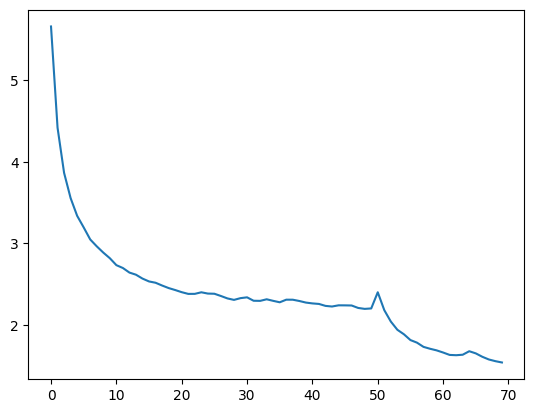

In [45]:
import matplotlib.pyplot as plt

plt.plot(train_loss)

In [46]:
print(f"True: {otoke.decode(t_dict['en'].squeeze(0).tolist())}")
print("\n")
print(f"True: {otoke.decode(t_dict['ne'].squeeze(0).tolist())}")
print("\n")
print(f"Predicted: {otoke.decode(dec_out.argmax(dim=-1).squeeze(0).tolist())}")

True: But the most urgently needed negotiations is for a revision of our present treaty with India which affects both the bulk of our foreign trade, which is with India, and potentially significant overseas trade which must pass through India.


True: नेपाल भारत भैत्री र वाणिज्य सन्धि विषय छलफल गरी उपयुक्त बनाउनु हालको निमित्त अत्यन्त आवश्य कुरो छ किनकि नेपालको व्यापार भारतसंग धेरै मात्रामा हुन्छ र समुद्रपारका देशहरुमा हुने हाम्रो व्यापार पनि भारत कै बाटो गरी चल्दछ।


Predicted: येपालमा �ारत रारय्री र खाणिज्यको वम्बन्धिको भयका �ाड कलाव कतुक्तिा� रनु आवश्यकबाटिमित्त चड राद आवशकादुराहरु� रुरैि प्रको व्यापारको स�तलंग नेपालेरै बढामा गुन्छन् यसुद्रपारका देशहरुमा खेनामा,�्यापार न वारत रेही बढर्षो गरी देशाहाव�छ।


In [31]:
# torch.save(model_rnn.state_dict(),'Ld_encoder.pt')
# torch.save(dec_rnn.state_dict(),'Ld_decoder.pt')

In [32]:
torch.save(model_rnn,'Lencoder.pt')
torch.save(dec_rnn,'Ldecoder.pt')

In [33]:

t_dict['en']=torch.tensor(otoke.encode('The country should look over its citizens')).unsqueeze(0)
t_dict['ne']=torch.tensor(otoke.encode('देशले आफ्ना नागरिकलाई हेर्नुपर्छ')).unsqueeze(0)

enc_out,enc_hid=model_rnn((t_dict['en']).to(device))
dec_out,dec_hidden=dec_rnn(encoder_outputs=enc_out,encoder_hidden=enc_hid,target_tensor=(t_dict['ne']).to(device))


In [34]:
otoke.decode(dec_out.argmax(dim=-1).squeeze(0).tolist())

'ा रूिक यसर्थिकिसिया र शिक्षाद स योको स �पर्ने�'